# Import thư viện

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, MaxAbsScaler 
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.ensemble import HistGradientBoostingClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_curve, auc
from sklearn import set_config
set_config(display='diagram') # Để trực quan hóa pipeline

import seaborn as sns
sns.set_theme(style="darkgrid")

# Khám phá dữ liệu

In [2]:
data_df = pd.read_csv('train.csv', index_col=0)
data_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Tiền xử lý

## Tách label dự đoán ra khỏi tập training

In [3]:
y_df = data_df["Survived"]
X_df = data_df.drop("Survived", axis=1)

## Khám phá dữ liệu

In [4]:
num_cols = ['Age', 'SibSp', 'Parch', 'Fare','Pclass']
df = X_df[num_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,Age,SibSp,Parch,Fare,Pclass
missing_ratio,19.90,0.0,0.0,0.0000,0.0
min,0.42,0.0,0.0,0.0000,1.0
lower_quartile,20.10,0.0,0.0,7.9000,2.0
median,28.00,0.0,0.0,14.5000,3.0
upper_quartile,38.00,1.0,0.0,31.0000,3.0
max,80.00,8.0,6.0,512.3292,3.0


Như chúng ta thấy cột tuổi có khá nhiều giá trị thiếu

In [5]:
pd.set_option('display.max_colwidth', 200) # Để nhìn rõ hơn
cat_cols = list(set(X_df.columns) - set(num_cols))
df = X_df[cat_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def num_values(df):
    return df.nunique()
def value_ratios(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
df.agg([missing_ratio, num_values, value_ratios])

,Name,Embarked,Cabin,Sex,Ticket
missing_ratio,0.0,0.2,77.1,0.0,0.0
num_values,891,3,147,2,681
value_ratios,"{'Braund, Mr. Owen Harris': 0.1, 'Boulos, Mr. Hanna': 0.1, 'Frolicher-Stehli, Mr. Maxmillian': 0.1, 'Gilinski, Mr. Eliezer': 0.1, 'Murdlin, Mr. Joseph': 0.1, 'Rintamaki, Mr. Matti': 0.1, 'Stephens...","{'S': 72.4, 'C': 18.9, 'Q': 8.7}","{'B96 B98': 2.0, 'G6': 2.0, 'C23 C25 C27': 2.0, 'C22 C26': 1.5, 'F33': 1.5, 'F2': 1.5, 'E101': 1.5, 'D': 1.5, 'C78': 1.0, 'C93': 1.0, 'E8': 1.0, 'D36': 1.0, 'B77': 1.0, 'C123': 1.0, 'E121': 1.0, '...","{'male': 64.8, 'female': 35.2}","{'347082': 0.8, 'CA. 2343': 0.8, '1601': 0.8, '3101295': 0.7, 'CA 2144': 0.7, '347088': 0.7, 'S.O.C. 14879': 0.6, '382652': 0.6, 'LINE': 0.4, 'PC 17757': 0.4, '17421': 0.4, '349909': 0.4, '113760'..."


Cột cabin có quá nhiều giá trị thiếu còn lại cũng không có gì đặc biệt

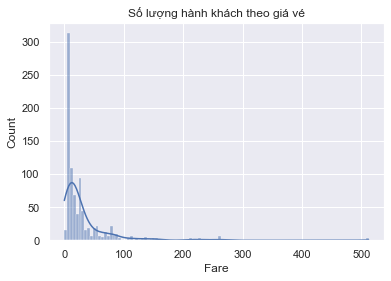

In [6]:
sns.histplot(data=data_df['Fare'], kde=True)
plt.title('Số lượng hành khách theo giá vé');

Cột fare có một cột mang giá trị lớn hơn khá nhiều so với các cột còn lại nên chúng ta không cần xử lý bằng cách chia nhỏ theo số lượng hành khách

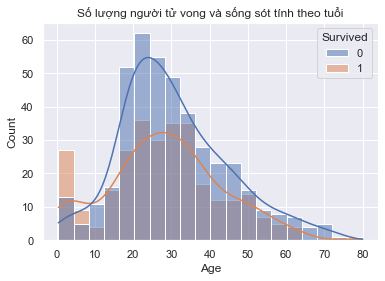

In [7]:
sns.histplot(data=data_df, x='Age', hue='Survived', kde = True)
plt.title('Số lượng người tử vong và sống sót tính theo tuổi');

Ở đây chúng ta có thể thấy những trẻ em từ 10-11 tuổi trở xuống có tỉ lệ sống sót cao hơn hẳn người lớn

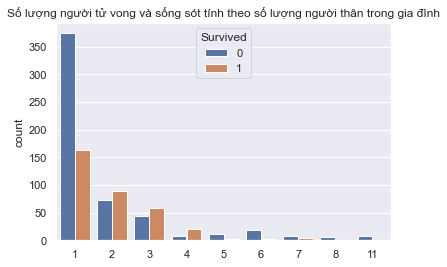

In [8]:
family = data_df['Parch'] + data_df['SibSp'] + 1
sns.countplot(data=data_df, x=family, hue='Survived')
plt.title('Số lượng người tử vong và sống sót tính theo số lượng người thân trong gia đình');

Ở đây chúng ta có thể thấy được sự khác biệt của nhóm tuổi từ 2 đến 4 so với phần còn lại

In [9]:
temp = data_df.copy()
title_col = temp.Name.str.extract(r'([a-zA-z]+)\.', expand=False)
temp['Title'] = title_col
temp['Title'] = temp['Title'].replace(['Capt', 'Col', 'Rev', 'Dr', 'Major'], 'Others')
temp['Title'] = temp['Title'].replace(['Countess', 'Lady', 'Sir', 'Jonkheer', 'Dona','Don'], 'Royal')
temp['Title'] = temp['Title'].replace('Mlle', 'Miss')
temp['Title'] = temp['Title'].replace('Ms', 'Miss')
temp['Title'] = temp['Title'].replace('Mme', 'Mrs')
show = temp.groupby(['Title', 'Pclass'])['Age'].agg(['mean'])
show.loc['Miss']

,mean
Pclass,
1,29.744681
2,22.560606
3,16.123188


In [10]:
temp.loc[(temp.Title=='Miss') & (temp.Parch!=0), 'Title']="FemaleChild"
show = temp.groupby(['Title', 'Pclass'])['Age'].agg(['mean'])
show.loc['Miss']

,mean
Pclass,
1,34.258065
2,30.375000
3,21.697674


In [11]:
show.loc['FemaleChild']

,mean
Pclass,
1,21.000000
2,10.538462
3,6.903846


Dựa vào 3 bảng chúng ta có thể thấy được việc những miss đi với bố mẹ thường xuyên là trẻ hơn và đó có thể là những trẻ em nữ vì trẻ em nam có thể gọi là master nhưng trẻ em nữ gọi chung là miss

In [12]:
show.loc['Mr']

,mean
Pclass,
1,41.580460
2,32.768293
3,28.724891


In [13]:
show.loc['Master']

,mean
Pclass,
1,5.306667
2,2.258889
3,5.350833


Vậy đúng là những trẻ em nam sẽ được gọi là master

## Xử lý dữ liệu

### 1. Gom nhóm phụ nữ và trẻ em nam

Dựa trên ý tưởng tại https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever, chúng ta sẽ tìm những trẻ em nam và phụ nữ bằng title master đối với trẻ em nam và giới tính female đối với phụ nữ. Chúng ta sẽ gom nhóm họ lại bằng họ của họ. 

Đầu tiên chúng ta có cột FamilyTotalCount thể hiện số lượng phụ nữ và trẻ em trong cùng 1 gia đình. Tiếp theo chúng ta có cột FamilySurvivedCount để thể hiện số người còn sống sót lại trong gia đình đó. Và từ 2 cột bên trên chúng ta có thể tính ra tỉ lệ sống sót của 1 gia đình đó bằng cách lấy cột FamilySurvivedCount chia cho cột FamilyTotalCount

Cuối cùng chúng ta sẽ tìm ra những người chỉ đi 1 mình. Những người đó là những người mà có FamilyTotalCount = 0

In [14]:
class WomanBoy(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y):        
        Xy = X.assign(Survived = y)
        title_col = Xy.Name.str.extract(r'([a-zA-z]+)\.', expand=False)
        surname_col = Xy.Name.str.extract('(.+),')
        Xy = Xy.assign(Surname = surname_col, Title = title_col)
        Xy['IsWomanOrChild'] = ((Xy.Title == 'Master') | (Xy.Sex == 'female'))
        Xy['Surname'] = Xy.Name.str.split(',').str[0]

        family = Xy.groupby(Xy.Surname).Survived
        Xy['FamilyTotalCount'] = family.transform(lambda s: s[Xy.IsWomanOrChild].fillna(0).count())
        Xy['FamilyTotalCount'] = Xy.mask(Xy.IsWomanOrChild, Xy.FamilyTotalCount - 1, axis=0).FamilyTotalCount
        Xy['FamilySurvivedCount'] = family.transform(lambda s: s[Xy.IsWomanOrChild].fillna(0).sum())
        Xy['FamilySurvivedCount'] = Xy.mask(Xy.IsWomanOrChild, 
                                            Xy.FamilySurvivedCount - Xy.Survived.fillna(0), axis=0).FamilySurvivedCount
        Xy['FamilySurvivalRate'] = (Xy.FamilySurvivedCount / Xy.FamilyTotalCount.replace(0, np.nan))
        Xy['Alone'] = Xy.FamilyTotalCount == 0
        
        self.Family_Total_Count = Xy['FamilyTotalCount']
        self.Family_Survived_Count = Xy['FamilySurvivedCount']
        self.Alone = Xy['Alone']
        self.Family_Survival_Rate = Xy['FamilySurvivalRate']
        
        return self
    def transform(self,X):
        X = X.assign(Alone = self.Alone, FamilyTotalCount = self.Family_Total_Count,
                     FamilySurvivedCount = self.Family_Survived_Count, FamilySurvivalRate = self.Family_Survival_Rate)
        return X

### 2. Tách cách xưng hô và xử lý những giá trị thiếu

Theo như chúng ta thấy từ tên thì mỗi người đều có những cách xưng hô khác nhau như Mr, Master, Miss và chúng ta có thể tách chúng ra vì khi sử dụng hẳn tên khi đó sẽ khiến mô hình fit quá mức cần thiết vào tập train. 

Sau khi tách tên và tìm hiểu cách cách xưng hô xong chúng ta có thể gom những cách xưng hô hiếm về những dạng common hơn và chúng ta sẽ có tổ hợp cuối cùng là Mr, Miss, Mrs, Master, Royal và những cách xuất hiện ít còn lại là Others.

Về việc chuyển tên gọi về Royal thì tham khảo ở https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner nhưng bổ sung thêm 1 số tên gọi trang trọng hoàng gia mà tác giả chưa cho vào như Dona, Jonkheer,... 

Đồng thời khi kiểm tra median tuổi thì chúng ta phát hiện ra những miss đi chung với cha mẹ có trung bình tuổi thấp hơn hẳn những miss đi 1 mình. Do trẻ em gái không có cách gọi riêng mà gọi chung là miss nên chúng ta có thể tách họ ra thành 1 cách gọi mới là FemaleChild

Tiếp theo chúng ta sẽ điền giá trị thiếu. Vì giá trị tuổi của nữ và nam, từng class và từng cách xưng hô có sự khác biệt rõ ràng nên chúng ta sẽ điền tuổi dựa vào median của 3 nhóm đó.

Đến phần giá vé thì thông thường giá vé sẽ tuỳ vào class trên tàu nên chúng ta sẽ điền bằng median của các class. Cuối cùng phần categorical là cảng xuất phát. Sau khi khai phá dữ liệu thì ta có thể thấy những người đi từ cảng S là nhiều hơn cả nên chúng ta sẽ điền lượng giá trị thiếu bằng giá trị xuất hiện nhiều nhất là S

In [15]:
class TitleAndFillMissing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y):
        return self
    def transform(self,X):
        #Lấy cách xưng hô
        title_col = X.Name.str.extract(r'([a-zA-z]+)\.', expand=False)
        X['Title'] = title_col
        
        #Chuyển đổi 1 số cách xưng hô hiếm về những dạng common hơn
        X['Title'] = X['Title'].replace(['Capt', 'Col', 'Rev', 'Dr', 'Major'], 'Others')
        X['Title'] = X['Title'].replace(['Countess', 'Lady', 'Sir', 'Jonkheer', 'Dona','Don'], 'Royal')
        X['Title'] = X['Title'].replace('Mlle', 'Miss')
        X['Title'] = X['Title'].replace('Ms', 'Miss')
        X['Title'] = X['Title'].replace('Mme', 'Mrs')
        X.loc[(X.Title=='Miss') & (X.Parch!=0), 'Title']="FemaleChild"

        
        #Nhóm lại thành 1 nhóm để điền tuổi thiếu vào        
        grouped = X.groupby(['Title','Pclass','Sex'])
        X.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))
        
        #Nhóm lại thành 1 nhóm để điền giá vé thiếu vào 
        grouped = X.groupby(['Pclass'])
        X.Fare = grouped.Fare.apply(lambda x: x.fillna(x.median()))
        
        #Điền Embarked thiếu bằng giá trị xuất hiện nhiều nhất
        X['Embarked'] = X['Embarked'].replace(np.nan,'S')
        
        return X

### 3. Xử lý và gom nhóm các thành viên trong gia đình

Theo như nội dung của tên columns thì Parch nghĩa là bố mẹ và con cái còn SibSp là anh chị em. Vì vậy thành viên gia đình chính là tổng số của 2 giá trị đó nên chúng ta sẽ gom lại thành 1

Theo như quan sát dựa trên tỉ lệ tử vong và độ lớn của gia đình thì chúng ta có thể tách gia đình ra làm 3 nhóm với nhóm từ 2 đến 4 là nhóm có tỉ lệ sống sót cao nhất và 2 nhóm kia có tỉ lệ sống sót khá thấp

In [16]:
class Family(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y):
        return self
    def transform(self,X):
        X['FamilySize'] = X['Parch'] + X['SibSp'] + 1
        X.loc[(X['FamilySize']==1),'Family'] = 0
        X.loc[(X['FamilySize']<=4) & (X['FamilySize']>1),'Family'] = 1
        X.loc[(X['FamilySize']>4),'Family'] = 2
       
        X.drop(columns = ['Parch','SibSp', 'FamilySize'], axis = 1, inplace = True)
        
        return X

### 4. Xử lý và gom nhóm tuổi

Chúng ta sẽ tách độ tuổi ra làm 4 phần dựa trên tổng số người trên tàu nhằm tránh việc mô hình quá fit vào tập train

Tiếp theo chúng ta có thể để ý rằng những đứa trẻ có tỉ lệ sống sót cao hơn hẳn và dựa trên phần mô hình hoá thì chúng ta sẽ thấy tại khoảng 10 - 11 tuổi trở về trước trẻ em có khả năng sống sót khá cao so với phần còn lại nên chúng ta sẽ gom chúng thành 1 nhóm và đó là cột Child. Ở đây sử dụng giá trị là 11 do theo như phần mô hình hoá thì đó là điểm giao nhau giữa tỉ lệ tử vong và tỉ lệ sống sót của mô hình

Vậy với những đứa trẻ không có tuổi do missing rồi sau đó điền lại bằng giá trị median khiến tuổi sẽ cao hơn con số 11 thì sao. Khi đó chúng ta sẽ thêm vào bằng cách bổ sung thêm vào cột Child nếu như đứa trẻ đó mang Title là Master hoặc là FemaleChild

In [17]:
#Age
class Age(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y):
        return self
    def transform(self,X):
        X['Child'] = X.Age.apply(lambda x: 1 if x <=  11 else 0)
        X['AgeCut'] = pd.qcut(X['Age'],4)
        
        boy_child_col = X['Name'].str.contains('Master.').astype(int)
        X = X.assign(BoyChild=boy_child_col)
        X['GirlChild'] = X['Title'].apply(lambda x : 1 if x == 'FemaleChild' else 0)        
        X['Child'] = X['Child'] + X['BoyChild'] + X['GirlChild']
        X['Child'] = X.Child.apply(lambda x: 1 if x >= 1 else x)
        X.drop(columns = ['Age','BoyChild','GirlChild'], axis = 1, inplace = True)
        
        return X

### 5. Loại bỏ những cột không cần thiết

Cột Name chúng ta đã sử dụng để lấy surname và title hiện tại chúng không còn giá trị sử dụng nữa như đã nói ở trên nên chúng ta sẽ loại bỏ nó.

Như chúng ta đã khám phá ở trên, cột cabin có đến tận 70% dữ liệu thiếu nên hầu như sẽ không giúp ích gì cả mà có thể khiến cho mô hình trở nên tệ hơn

In [18]:
class ColDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y):
        return self
    def transform(self,X):

        X.drop(columns = ['Name','Cabin'], axis = 1, inplace = True)
        
        return X

## Training mô hình

## Thiết lập pipeline

Chúng ta sẽ ghép những bước xử lý dữ liệu trên thành 1 pipeline. Sau đó chúng ta sẽ đưa những cột có dạng categorical để one-hot encoding chúng. Cuối cùng chúng sa sẽ standard scaling cả tập dữ liệu lại bằng hàm StandardScaler.

In [19]:
cate_cols = ['Embarked','Pclass','Title','Sex','Ticket','AgeCut','Alone']
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse = False, handle_unknown='ignore'))])
col_transformer = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cate_cols)])
change_columns = Pipeline(steps = [
    ('wb',WomanBoy()),
    ('timi', TitleAndFillMissing()),
    ('fami', Family()),
    ('age',Age()),
    ('drop', ColDropper())
])
preprocess_pipeline = Pipeline(steps=[
    ('change_col', change_columns),
    ('col_trans', col_transformer),
    ('std', StandardScaler()),
])

In [20]:
check = change_columns.fit_transform(X_df,y_df)
check

,Pclass,Sex,Ticket,Fare,Embarked,Alone,FamilyTotalCount,FamilySurvivedCount,FamilySurvivalRate,Title,Family,Child,AgeCut
PassengerId,,,,,,,,,,,,,
1,3,male,A/5 21171,7.2500,S,True,0,0,NaN,Mr,1.0,0,"(21.0, 26.0]"
2,1,female,PC 17599,71.2833,C,True,0,0,NaN,Mrs,1.0,0,"(36.75, 80.0]"
3,3,female,STON/O2. 3101282,7.9250,S,True,0,0,NaN,Miss,0.0,0,"(21.0, 26.0]"
4,1,female,113803,53.1000,S,True,0,0,NaN,Mrs,1.0,0,"(26.0, 36.75]"
5,3,male,373450,8.0500,S,False,1,1,1.0,Mr,0.0,0,"(26.0, 36.75]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,male,211536,13.0000,S,True,0,0,NaN,Others,0.0,0,"(26.0, 36.75]"
888,1,female,112053,30.0000,S,False,1,1,1.0,Miss,0.0,0,"(0.419, 21.0]"
889,3,female,W./C. 6607,23.4500,S,True,0,0,NaN,FemaleChild,1.0,1,"(0.419, 21.0]"


Vậy những feature cuối cùng chúng ta lấy là: 
Pclass: Class của hành khách
<br>Sex: Giới tính của hành khách
<br>Ticket: Vé của hành khách
<br>Fare: Giá tiền vé của hành khách
<br>Embarked: Cảng hành khách dùng khi lên tàu
<br>Alone: Người phụ nữ hoặc trẻ em nam đi 1 mình
<br>FamilyTotalCount: Tổng số phụ nữ và trẻ em nam trong 1 gia đình
<br>FamilySurvivedCount: Tổng số phụ nữ và trẻ em nam còn sống trong 1 gia đình
<br>FamilySurvivalRate: Tỉ lệ người sống sót trong 1 gia đình tạo ra bởi phụ nữ và trẻ em nam
<br>Family: Loại gia đình mà người đó thuộc về: 0 đối với người đi 1 mình, 1 đối với gia đình 2-4 người và 2 đối với gia đình trên 4 người
<br>Child: Trẻ em 
<br>AgeCut: Khoảng tuổi được cắt ra dựa trên trung bình số hành khách

Chúng ta sẽ tạo ra 1 pipeline hoàn chỉnh. Với mô hình này em sử dụng 1 siêu tham số là max_depth vì theo em thấy tập dữ liệu này khá nhỏ nên việc max_depth quá cao sẽ dẫn đến việc bị overfitting. Khi em thử với giá trị max_depth = 3 thì giá trị AUC trung bình của em đạt 85.91% nhưng điểm trên leaderboard chỉ đạt 78.70% còn khi thử với giá trị là 2 thì AUC trung bình của em thấp hơn 1 tí 84.82% nhưng điểm trên leaderboard thì được 80.14%

In [21]:
LGBM_pipeline = Pipeline(steps=[
    ('prep_pipeline',preprocess_pipeline),
    ('gradient_boosting',LGBMClassifier(max_depth = 2))])

### Training

Chúng ta sẽ chia mô hình thành 5 phần ngẫu nhiên và chúng ta sẽ tiến hành cho máy học với 4 phần và dự đoán đối với tập test để đưa ra tỉ lệ có khả năng là đối với đối tượng đó có bao nhiêu % khả năng là 0 (chết) và 1 (sống) và lưu vào 1 dataframe để xử lý sau. Xoay tua liên tục 5 lần đến khi toàn bộ mô hình đều đã được học và được dự đoán

Sau đó chúng ta sẽ kiểm tra điểm AUC của mô hình bằng tập validation chưa được training đã được tách ra để xem giá trị AUC của từng đợt train và trung bình của toàn mô hình là bao nhiêu

In [22]:
NFOLD = 5
skf = StratifiedKFold(n_splits=NFOLD, shuffle=True)
test_df = pd.read_csv('test.csv', index_col=0)
LGBM = []
probs = pd.DataFrame(np.zeros((len(test_df), NFOLD * 2)), 
                     columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, NFOLD + 1) for j in range(2)])
for fold, (trn_idx, val_idx) in enumerate(skf.split(X_df, y_df), 1):
    print('Fold {}'.format(fold))
    LGBM_pipeline.fit(X_df.iloc[trn_idx], y_df.iloc[trn_idx])
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = LGBM_pipeline.predict_proba(test_df)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = LGBM_pipeline.predict_proba(test_df)[:, 1]
    val_fpr, val_tpr, val_thresholds = roc_curve(y_df.iloc[val_idx], LGBM_pipeline.predict_proba(X_df.iloc[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)
    print ('auc score val ' + str(fold) + ': ' + str(val_auc_score) + '\n')
    LGBM.append(val_auc_score)
print('Auc score trung bình:' + str(sum(LGBM)/NFOLD))

Fold 1
auc score val 1: 0.7790513833992094

Fold 2
auc score val 2: 0.8286096256684492

Fold 3
auc score val 3: 0.8994652406417113

Fold 4
auc score val 4: 0.8921791443850268

Fold 5
auc score val 5: 0.8286796968488233

Auc score trung bình:0.8455970181886439


### Dự đoán

Chúng ta sẽ lấy tỉ lệ dự đoán khả năng sống chết từ 5 mô hình ở trên và lấy trung bình của chúng. Nếu như tỉ lệ sống cao hơn thì chúng ta sẽ dự đoán đối tượng đó là 1 và ngược lại

In [23]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
class_unsurvived = [col for col in probs.columns if col.endswith('Prob_0')]
probs['1'] = probs[class_survived].sum(axis=1) / NFOLD
probs['0'] = probs[class_unsurvived].sum(axis=1) / NFOLD
probs['pred'] = 0
pos = probs[probs['1'] >= probs['0']].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

Lưu lại dữ liệu dự đoán vào file csv để submit lên kaggle

In [24]:
pass_ID = test_df.index.values
my_preds = pd.DataFrame({'PassengerId': pass_ID, 'Survived': y_pred}, 
                        columns=['PassengerId','Survived']).set_index('PassengerId')
my_preds.to_csv('Final.csv')

# Kết quả

Kết quả submit
![title](KaggleSubmit.png)

Số lần submit
![title](NumKaggleSubmit.png)

Kết quả trên leaderboard
![title](KaggleLeaderboard.png)